<a href="https://colab.research.google.com/github/imraunav/Computer-vision-EE511/blob/main/cv-EfficientNetb1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import random_split
from tqdm import tqdm

In [3]:
# Download training data from open datasets.
train_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform= transforms.Compose([
    transforms.Resize(64),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]),
)

# Download test data from open datasets.
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]),
)

100%|██████████| 170498071/170498071 [00:05<00:00, 29983886.96it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [4]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_dataloader=DataLoader(test_data,batch_size=batch_size*2, num_workers=2, pin_memory=True)

for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 64, 64])
Shape of y: torch.Size([64]) torch.int64


In [5]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [12]:
model = torch.hub.load('pytorch/vision', 'efficientnet_b1', weights='EfficientNet_B1_Weights.IMAGENET1K_V2')

Downloading: "https://github.com/pytorch/vision/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 104MB/s]


In [13]:
print(model)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
# for param in model.parameters():
#     param.requires_grad = False

In [14]:
model.classifier[1] = nn.Linear(1280, 10)

In [15]:
for param in model.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [16]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    batch_losses = []
    for batch in tqdm(dataloader):
        X, y = batch
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = nn.functional.log_softmax(model(X), dim=-1)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())

    return sum(batch_losses)/len(batch_losses)

In [17]:
model.to(device)
print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [19]:
max_epoch = 25

train_loss = []
for epoch in range(max_epoch):
  print(f"Epoch {epoch+1}")
  epoch_loss = train(train_dataloader,model,loss_fn,optimizer)
  print(f"Train loss: {epoch_loss}")
  train_loss.append(epoch_loss)

Epoch 1


100%|██████████| 782/782 [01:21<00:00,  9.63it/s]


Train loss: 0.511306869976051
Epoch 2


100%|██████████| 782/782 [01:15<00:00, 10.41it/s]


Train loss: 0.2749885684617645
Epoch 3


100%|██████████| 782/782 [01:14<00:00, 10.43it/s]


Train loss: 0.2076177603810492
Epoch 4


100%|██████████| 782/782 [01:13<00:00, 10.59it/s]


Train loss: 0.17250239206215992
Epoch 5


100%|██████████| 782/782 [01:14<00:00, 10.55it/s]


Train loss: 0.14190154827064108
Epoch 6


100%|██████████| 782/782 [01:13<00:00, 10.61it/s]


Train loss: 0.11940507173997915
Epoch 7


100%|██████████| 782/782 [01:14<00:00, 10.57it/s]


Train loss: 0.10651276328677164
Epoch 8


100%|██████████| 782/782 [01:14<00:00, 10.47it/s]


Train loss: 0.09625562900067557
Epoch 9


100%|██████████| 782/782 [01:15<00:00, 10.40it/s]


Train loss: 0.08856728426752436
Epoch 10


100%|██████████| 782/782 [01:13<00:00, 10.59it/s]


Train loss: 0.07915440900697876
Epoch 11


100%|██████████| 782/782 [01:13<00:00, 10.67it/s]


Train loss: 0.07707856676441228
Epoch 12


100%|██████████| 782/782 [01:13<00:00, 10.59it/s]


Train loss: 0.0693286394166267
Epoch 13


100%|██████████| 782/782 [01:13<00:00, 10.66it/s]


Train loss: 0.060201324448358656
Epoch 14


100%|██████████| 782/782 [01:14<00:00, 10.49it/s]


Train loss: 0.06041748102491155
Epoch 15


100%|██████████| 782/782 [01:15<00:00, 10.35it/s]


Train loss: 0.05304479569225284
Epoch 16


100%|██████████| 782/782 [01:13<00:00, 10.60it/s]


Train loss: 0.05257747433786376
Epoch 17


100%|██████████| 782/782 [01:13<00:00, 10.66it/s]


Train loss: 0.04912724679191102
Epoch 18


100%|██████████| 782/782 [01:13<00:00, 10.64it/s]


Train loss: 0.04700053301479077
Epoch 19


100%|██████████| 782/782 [01:13<00:00, 10.71it/s]


Train loss: 0.0491283849814235
Epoch 20


100%|██████████| 782/782 [01:14<00:00, 10.44it/s]


Train loss: 0.044185959524415494
Epoch 21


100%|██████████| 782/782 [01:14<00:00, 10.44it/s]


Train loss: 0.04340802076658385
Epoch 22


100%|██████████| 782/782 [01:14<00:00, 10.55it/s]


Train loss: 0.039510457684746536
Epoch 23


100%|██████████| 782/782 [01:13<00:00, 10.60it/s]


Train loss: 0.039315285029760956
Epoch 24


100%|██████████| 782/782 [01:13<00:00, 10.59it/s]


Train loss: 0.040847899550606276
Epoch 25


100%|██████████| 782/782 [01:13<00:00, 10.60it/s]

Train loss: 0.0369124666452655


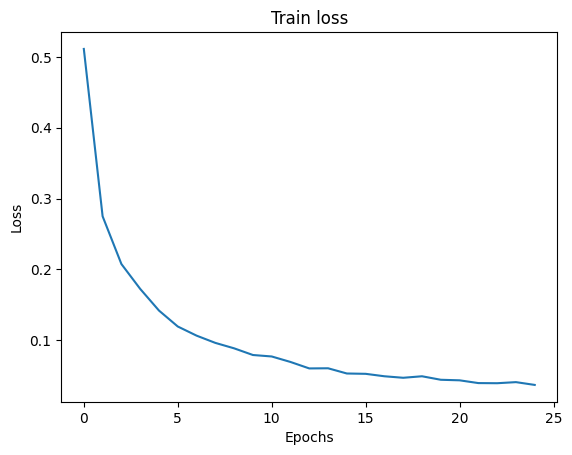

In [20]:
import matplotlib.pyplot as plt

plt.plot(train_loss)
plt.title("Train loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [21]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [22]:
test(test_dataloader,model,loss_fn)

Test Error: 
 Accuracy: 92.0%, Avg loss: 0.329872 

